In [1]:
# iPython specific stuff
%matplotlib inline
import IPython.display

In [2]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter


### Make Spectrogram

In [3]:
# Mostly modified or taken from https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw,ws),dtype = a.dtype)

    for i in xrange(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start : stop]

    return out

def halfoverlap(X, window_size):
    """
    Create an overlapped version of X using 50% of window_size as overlap.
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    window_step = window_size // 2
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))
    num_frames = len(X) // window_step - 1
    row_stride = X.itemsize * window_step
    col_stride = X.itemsize
    X_strided = as_strided(X, shape=(num_frames, window_size),
                           strides=(row_stride, col_stride))
    return X_strided

def stft(X, fftsize=128, step="half", mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()
    if step == "half":
        X = halfoverlap(X, fftsize)
    else:
        X = overlap(X, fftsize, step)
    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def pretty_spectrogram(d,log = True, thresh= 5, fft_size = 512, step_size = 64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: 
    """
    specgram = np.abs(stft(d, fftsize=fft_size, step=step_size, real=False,
        compute_onesided=True))
  
    if log == True:
        specgram /= specgram.max() # volume normalize to max 1
        specgram = np.log10(specgram) # take log
        specgram[specgram < -thresh] = -thresh # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh # set anything less than the threshold as the threshold
    
    return specgram


In [4]:
### Settings ###
fft_size = 512
step_size = fft_size/4
spec_thresh = 4 # threshold for spectrograms
lowcut = 500 # Hz
highcut = 15000 # Hz

In [5]:
# Grab your wav and filter it
mywav = '/mnt/lintu/home/Gentnerlab/share/stimuli/brad_songs/G117-23.wav'
rate, data = wavfile.read(mywav)
data = data[0:rate*10] # grab the first 10 seconds
data = butter_bandpass_filter(data, lowcut, highcut, rate, order=1)

/home/AD/tsainbur/.conda/envs/tim_tf/lib/python2.7/site-packages/scipy/io/wavfile.py:221: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [6]:
wav_spectrogram = pretty_spectrogram(data.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)

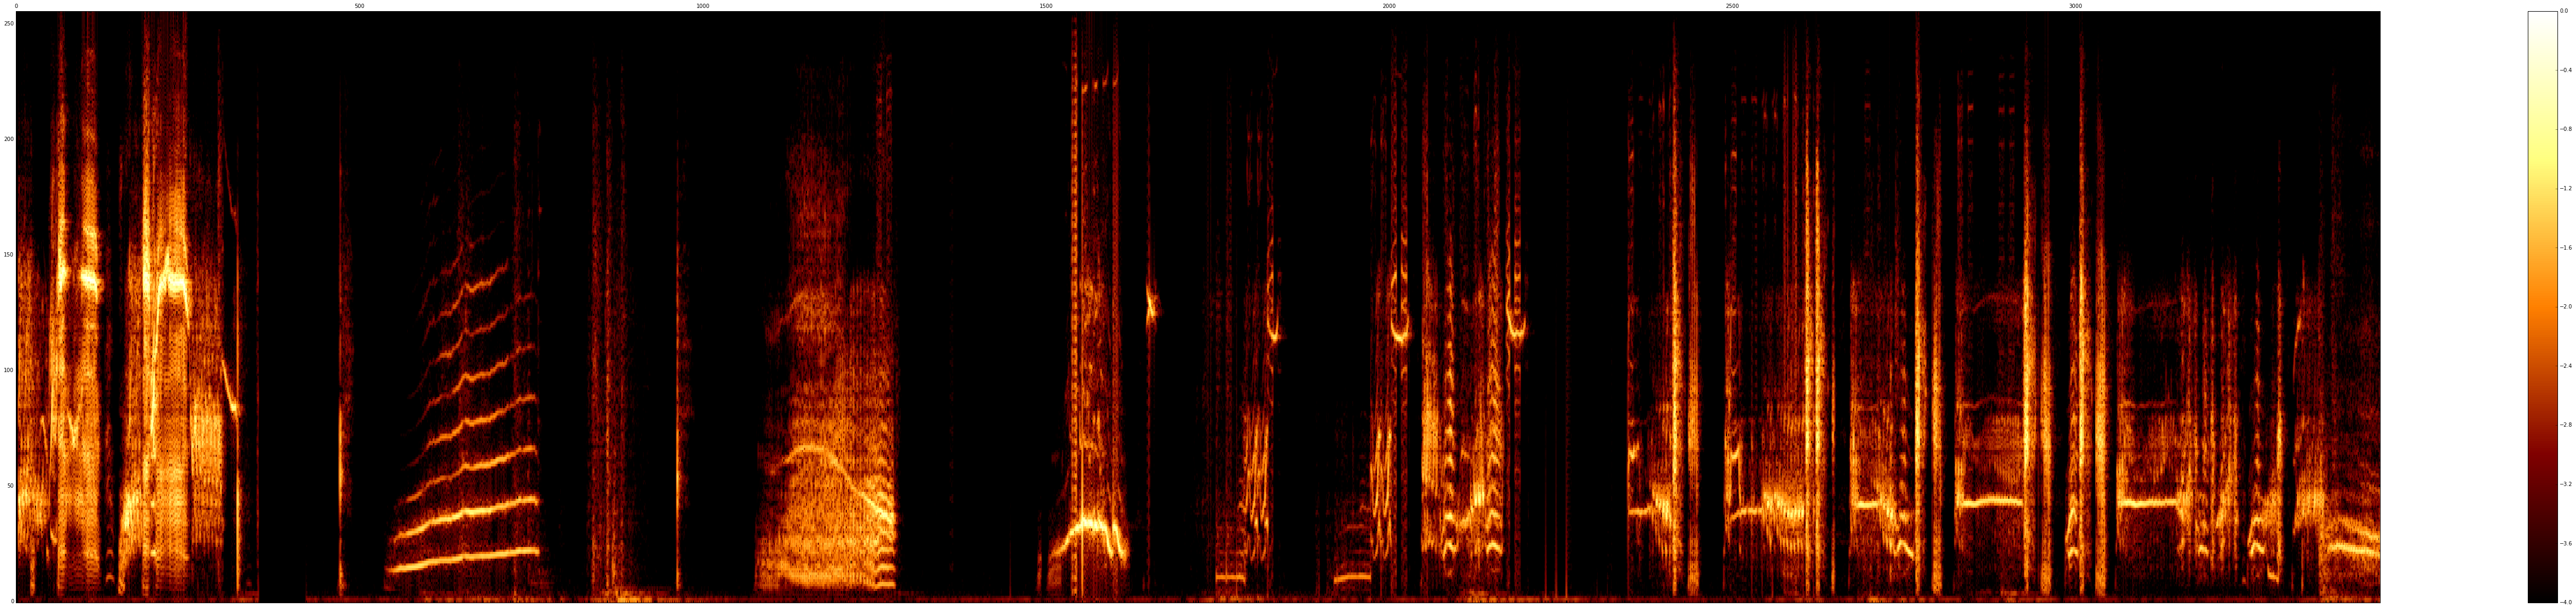

In [7]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(100,20))
cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)

In [8]:
# Play the song
IPython.display.Audio(data=data, rate=rate)

### Invert Spectrogram

In [9]:
import copy

In [10]:
# Also mostly modified or taken from https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
def invert_pretty_spectrogram(X_s, log = True, fft_size = 512, step_size = 512/4, n_iter = 10):
    
    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t

def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    reg = np.max(X_s) / 1E8
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=True)
        else:
            # Calculate offset was False in the MATLAB version
            # but in mine it massively improves the result
            # Possible bug in my impl?
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=False)
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[:len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                             set_zero_phase=False)
    return np.real(X_t)

def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype('float64')
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print("WARNING: Large step size >50\% detected! "
                      "This code works best with high overlap - try "
                      "with 75% or greater")
                offset_size = step
            offset = xcorr_offset(wave[wave_start:wave_start + offset_size],
                                  wave_est[est_start:est_start + offset_size])
        else:
            offset = 0
        wave[wave_start:wave_end] += win * wave_est[
            est_start - offset:est_end - offset]
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1E-6)
    return wave

def xcorr_offset(x1, x2):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype('float32'), x2[::-1].astype('float32'))
    corrs[:half] = -1E30
    corrs[-half:] = -1E30
    offset = corrs.argmax() - len(x1)
    return offset

In [11]:
recovered_audio = invert_pretty_spectrogram(wav_spectrogram, fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)

In [12]:
IPython.display.Audio(data=recovered_audio, rate=rate)

In [13]:
# Make a spectrogram of the inverted stuff
inverted_spectrogram = pretty_spectrogram(recovered_audio.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)

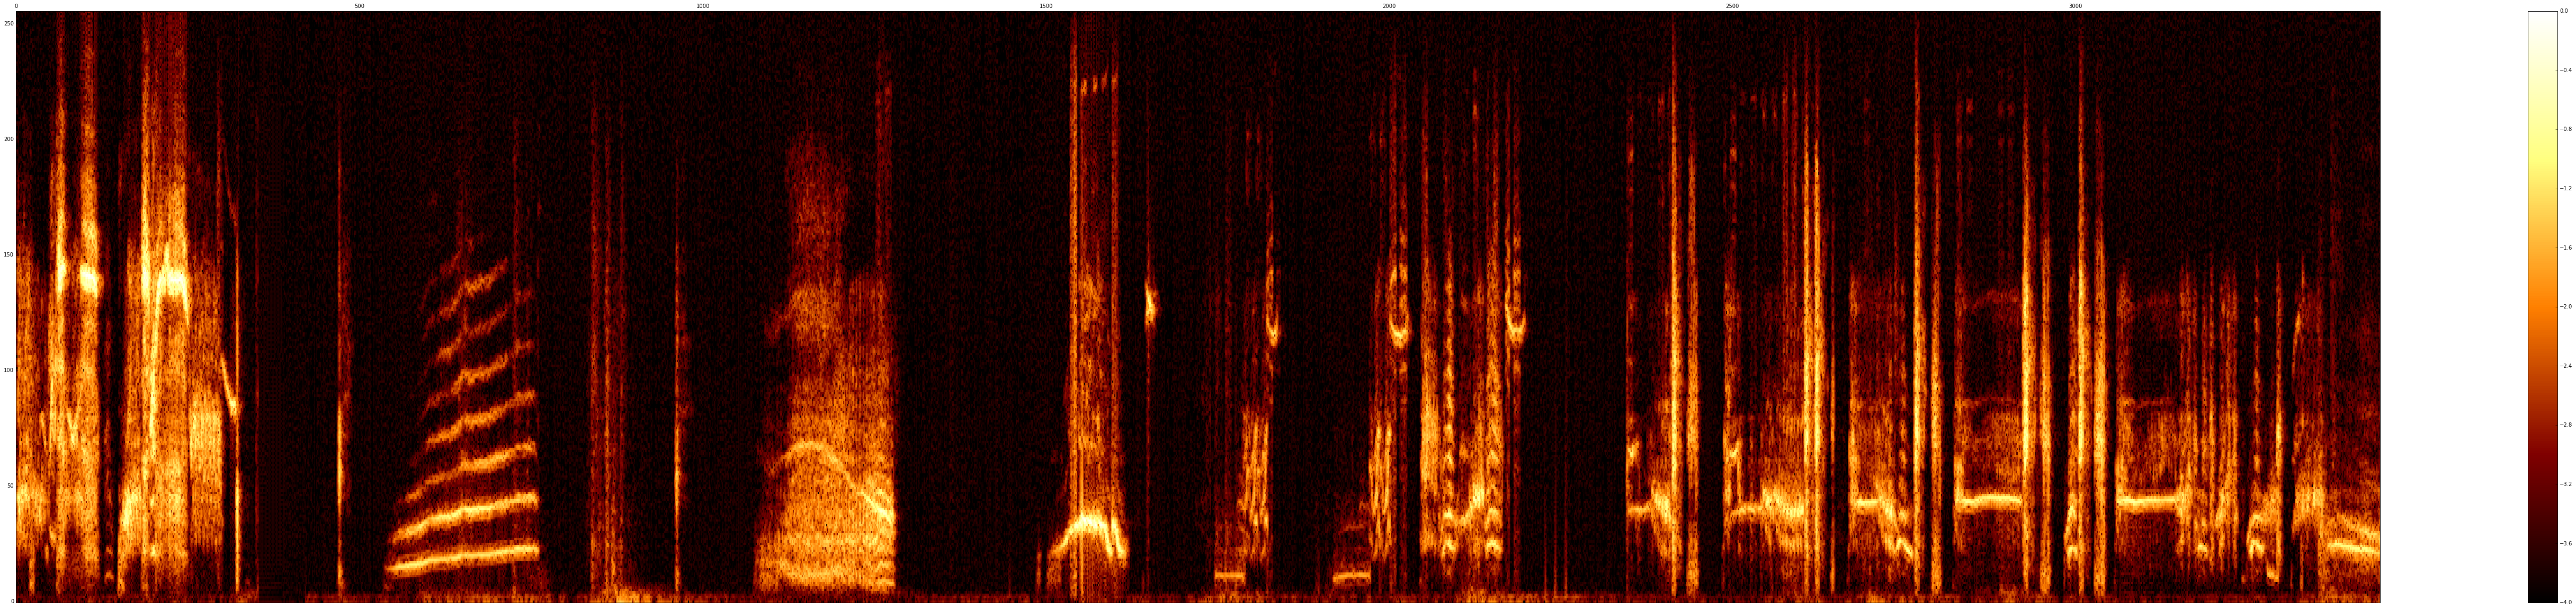

In [14]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(100,20))
cax = ax.matshow(np.transpose(inverted_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)